In [1]:
import sys
sys.path.append('..')

from spyral.core.constants import QBRHO_2_P
from spyral.core.run_stacks import form_run_string

from spyral_utils.nuclear import NuclearDataMap
from spyral_utils.nuclear.target import GasTarget, load_target
from spyral_utils.plot import Histogrammer

from pathlib import Path
from scipy.constants import physical_constants, torr
from scipy.integrate import quad
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import vector
import lmfit
import math

%matplotlib widget

In [2]:
# Load data config
workspace_path = Path("D:\\e20009_analysis")
target_material_path = Path("C:\\Users\\zachs\\Desktop\\e20009_analysis\\e20009_analysis\\e20009_parameters\\e20009_target.json")

solver_result_path = workspace_path / "InterpLeastSqSolver"
beam_events_path = workspace_path / "beam_events"

# Run number range (inclusive)
run_min = 108
run_max = 366

# The nucleus we observe (the one fitted)
ejectile_z = 1
ejectile_a = 1

# The incoming nucleus (the beam)
projectile_z = 4
projectile_a = 10

# The target nucleus
target_z = 1
target_a = 2

residual_z = target_z + projectile_z - ejectile_z
residual_a = target_a + projectile_a - ejectile_a

if residual_z < 0:
    raise Exception(f"Illegal nuclei! Residual Z: {residual_z}")
if residual_a < 1:
    raise Exception(f"Illegal nuclei! Residual A: {residual_a}")

In [3]:
# Setup nuclear data objects
nuclear_map = NuclearDataMap()

target_material = load_target(target_material_path, nuclear_map)
if not isinstance(target_material, GasTarget):
    print('Target error!')

ejectile = nuclear_map.get_data(ejectile_z, ejectile_a)
projectile = nuclear_map.get_data(projectile_z, projectile_a)
target = nuclear_map.get_data(target_z, target_a)
residual = nuclear_map.get_data(residual_z, residual_a)
print(f"Reaction: {target}({projectile}, {ejectile}){residual}")
print(f"Target material: {target_material.ugly_string}")

Reaction: 2H(10Be, 1H)11Be
Target material: (Gas)2H2


In [4]:
# Define parameters used for analysis
proj_energy_start = 93.5        # Units of MeV. Initial beam energy

min_z = 0.004    # Units of meters. Minimum z value of vertex (inclusive)
max_z = 0.958    # Units of meters. Maximum z value of vertex (inclusive)

min_cm = 18.0    # Units of degrees. Minimum center-of-mass scattering angle for events in excitation spectrum (inclusive)
max_cm = 30.0   # Units of degrees. Maximum center-of-mass scattering angle for events in excitation spectrum (inclusive)

ex_en_min = 3.1     # Units of MeV. Minimum excitation energy gate for angular distribution (inclusive)
ex_en_max =  3.7    # Units of MeV. Maximum excitation energy gate for angular distribution (inclusive or exclusive depending on binning)

redchi = 10     # Maximum reduced chi squared value (inclusive)

ex_energy_min = -0.5        # Smallest allowed excitation energy in histogram (inclusive)
ex_energy_max = 4.5    # Largest allowed excitation energy in histogram (inclusive)
ex_energy_bins = 90        # Number of bins in excitation energy histogram

ang_dist_bins =  9     # Number of bins in angular distribution

In [5]:
# Define parameters used for finding the cross section

downscale_factor = 1000

ic_min_val = 300.0
ic_max_val = 850.0

boltzmann = physical_constants["Boltzmann constant"][0]    # Units of Joules / Kelvin
torr_2_pascal = torr    # Convert from torr to pascals
pressure = 600 # Units of torr
temperature = 273.15    # Units of Kelvin, STP
stoich = 2 # Stoichiometry of gas

In [6]:
# Create dictionary to store results from analysis

results = {}

# Add keys for result parameters
results["polar"] = np.empty(0, float)
results["kinetic_energy"] = np.empty(0, float)
results["azimuthal"] = np.empty(0, float)
results["ex_energy"] = np.empty(0, float)
results["cm_polar"] = np.empty(0, float)
results["chisq"] = np.empty(0, float)
results["z_vert"] = np.empty(0, float)

# Create histogram tool
grammer = Histogrammer()

In [7]:
# Analysis data

target_vector = vector.array({"px": [0.0], "py": [0.0], "pz": [0.0], "E": [target.mass]})
for run in range(run_min, run_max+1):
    df = None
    path = solver_result_path / f"run_{run:04d}_{ejectile.isotopic_symbol}.parquet"
    if not path.exists():
        continue
    df = pl.scan_parquet(path)


    #Apply gates to data
    df = (df.filter((pl.col("vertex_z") >= min_z) 
                   & (pl.col("vertex_z") <= max_z)
                   & (pl.col("redchisq") <= redchi)
                   )
            .collect()
    )

    # Construct the projectile vectors (beam)
    vertices = df.select(['vertex_x', 'vertex_y', 'vertex_z']).to_numpy()
    distances = np.linalg.norm(vertices, axis=1)
    projectile_ke = proj_energy_start - target_material.get_energy_loss(projectile, proj_energy_start, distances)
    projectile_vector = vector.array({
        "px": np.zeros(len(projectile_ke)),
        "py": np.zeros(len(projectile_ke)),
        "pz": np.sqrt(projectile_ke * (projectile_ke + 2.0 * projectile.mass)),
        "E": projectile_ke + projectile.mass
    })

    # Construct the ejectile vectors (detected)
    brho = df.select('brho').to_numpy().flatten()
    momentum = df.select('brho').to_numpy().flatten() * float(ejectile.Z) * QBRHO_2_P
    kinetic_energy = np.sqrt(momentum**2.0 + ejectile.mass**2.0) - ejectile.mass
    polar = df.select('polar').to_numpy().flatten()
    az = df.select('azimuthal').to_numpy().flatten()
    ejectile_vector = vector.array({
        "px": momentum * np.sin(polar) * np.cos(az),
        "py": momentum * np.sin(polar) * np.sin(az),
        "pz": momentum * np.cos(polar),
        "E": np.sqrt(momentum**2.0 + ejectile.mass**2.0)
    })

    # Get reduced chi-squared information
    cs = df.select('redchisq').to_numpy().flatten()

    # Get vertex z position
    zvert=df.select('vertex_z').to_numpy().flatten()

    # Do the kinematics
    residual_vector = target_vector + projectile_vector - ejectile_vector # type: ignore
    ex_energy = residual_vector.mass - residual.mass # Excitation energy is "extra" mass

    # Calculate CM scattering angle 
    cm_vec = ejectile_vector.boostCM_of(projectile_vector + target_vector)
    cm_polar = np.pi - cm_vec.theta

    # Fill histograms and arrays
    results["polar"] = np.append(results["polar"], polar)
    results["kinetic_energy"] = np.append(results["kinetic_energy"], kinetic_energy)
    results["azimuthal"] = np.append(results["azimuthal"], az)
    results["ex_energy"] = np.append(results["ex_energy"], ex_energy)
    results["cm_polar"] = np.append(results["cm_polar"], cm_polar)
    results["chisq"] = np.append(results["chisq"], cs)
    results["z_vert"] = np.append(results["z_vert"], zvert)

# print(f"Median chisq: {np.median(results["chisq"])}")

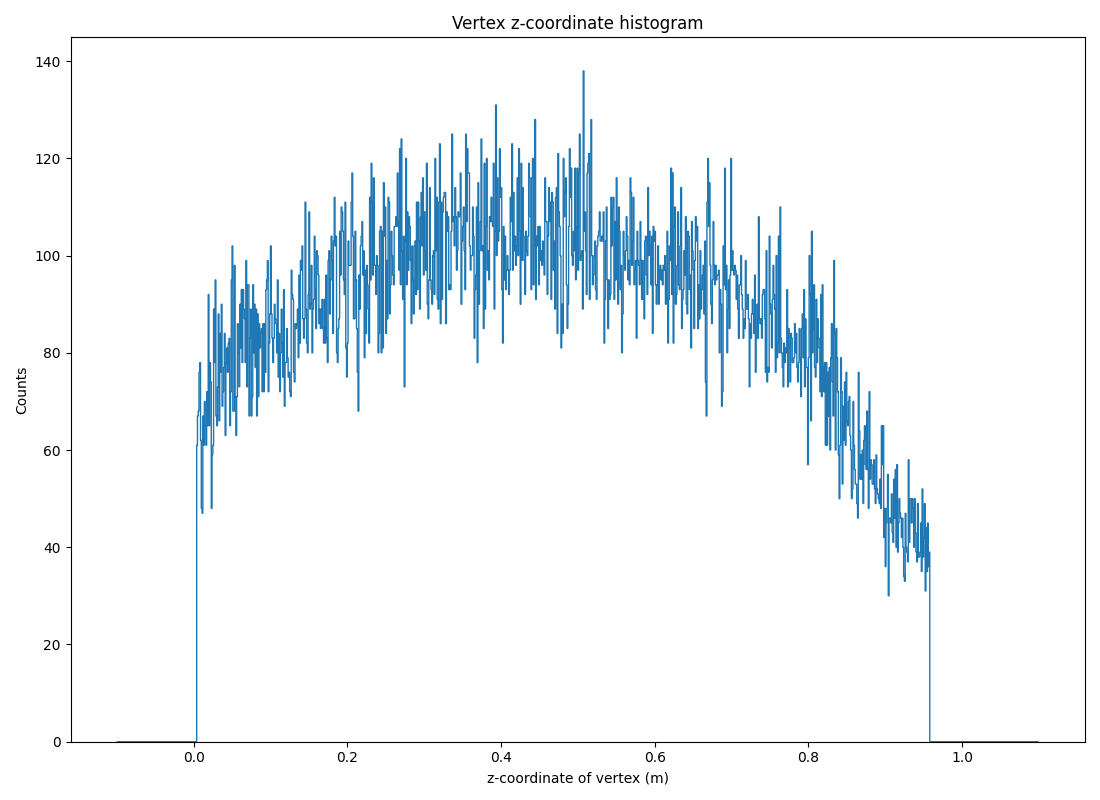

In [8]:
# Plot vertex z-ccordinate histogram

grammer.add_hist1d('z_vert', 1200, (-0.1, 1.1))
grammer.fill_hist1d('z_vert', results["z_vert"])
vertz = grammer.get_hist1d("z_vert")

fig, ax = plt.subplots(1,1)
ax.stairs(vertz.counts, edges=vertz.bins)
ax.set_title(f"Vertex z-coordinate histogram")
ax.set_xlabel("z-coordinate of vertex (m)")
ax.set_ylabel("Counts")
fig.set_figheight(8.0)
fig.set_figwidth(11.0)
fig.tight_layout()

In [9]:
# Perform analysis of beam events

grammer.add_hist1d('beam_events_ic', 4095, (0.0, 4095.0))

bad_triggers = 0
total_triggers = 0
for run in range(run_min, run_max+1):
    df = None
    try:
        path = beam_events_path / f"{form_run_string(run)}.parquet"
        df = pl.read_parquet(path)
    except Exception:
        continue
    
    # Get bad trigger counts
    bad_triggers += df.select(pl.col("ic_amplitude").list.explode()).null_count().item()

    # Apply appropriate analysis gates
    df = df.filter((pl.col("ic_multiplicity") == 1.0)
                 & (pl.col("ic_sca_multiplicity") == 1.0)
                 & (abs(pl.col("ic_sca_multiplicity") - pl.col("ic_multiplicity")) <= 10))
    

    ic_amp = df.select(pl.col('ic_amplitude').list.get(0, null_on_oob=True)).to_numpy().flatten()

    
    grammer.fill_hist1d('beam_events_ic', ic_amp)

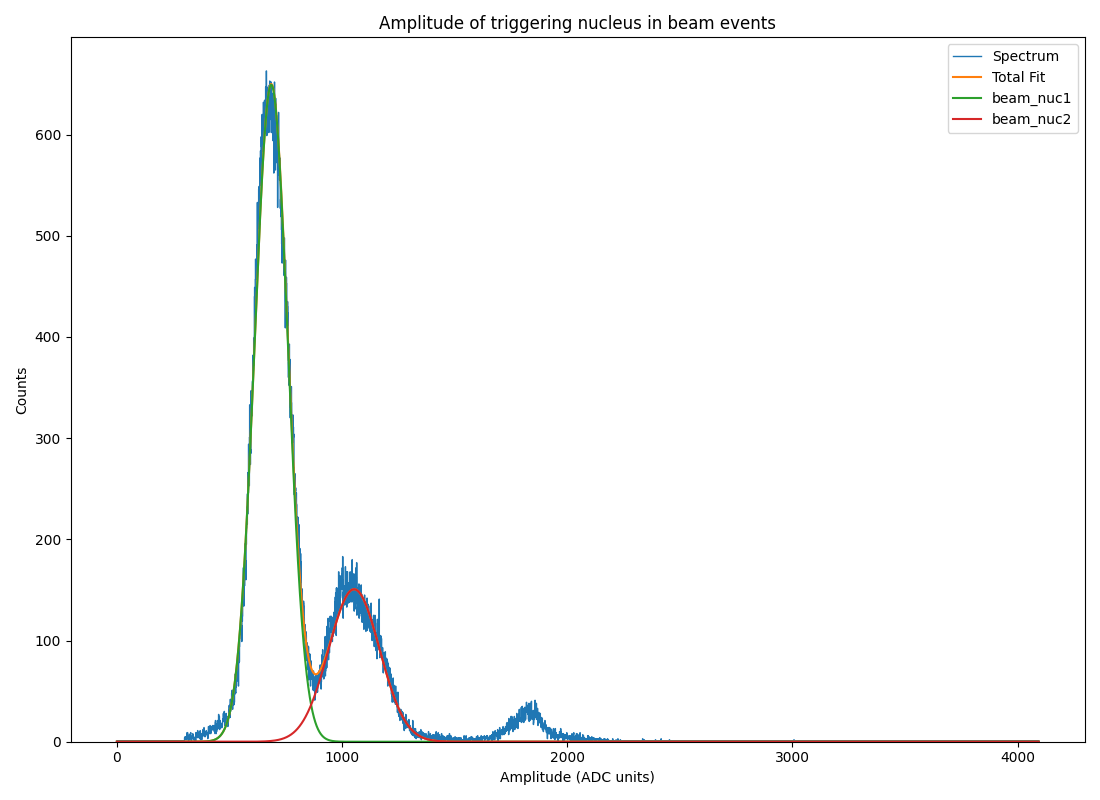

In [10]:
# Plot IC histogram

beam_events_ic = grammer.get_hist1d('beam_events_ic')

beam_nuc1 = lmfit.models.GaussianModel(prefix="beam_nuc1_")
beam_nuc1_bins, beam_nuc1_counts = beam_events_ic.get_subrange((ic_min_val, ic_max_val))
beam_nuc1_bins += 0.5 * beam_events_ic.bin_width
beam_nuc1_counts[beam_nuc1_counts == 0.0] = 1.0
beam_nuc1_weights = 1.0/np.sqrt(beam_nuc1_counts)
beam_nuc1_weights[beam_nuc1_counts == 0.0] = 1.0
pars = beam_nuc1.guess(x=beam_nuc1_bins, data=beam_nuc1_counts, weights=beam_nuc1_weights)
pars["beam_nuc1_amplitude"].min = 0.0

beam_nuc2 = lmfit.models.GaussianModel(prefix="beam_nuc2_")
beam_nuc2_bins, beam_nuc2_counts = beam_events_ic.get_subrange((ic_max_val, 1500))
beam_nuc2_bins += 0.5 * beam_events_ic.bin_width
beam_nuc2_counts[beam_nuc2_counts == 0.0] = 1.0
beam_nuc2_weights = 1.0/np.sqrt(beam_nuc2_counts)
beam_nuc2_weights[beam_nuc2_counts == 0.0] = 1.0
pars.update(beam_nuc2.guess(x=beam_nuc2_bins, data=beam_nuc2_counts, weights=beam_nuc2_weights))
pars["beam_nuc2_amplitude"].min = 0.0

total_fit = beam_nuc1 + beam_nuc2
total_bins = beam_events_ic.bins[:-1] + beam_events_ic.bin_width/2
total_counts = beam_events_ic.counts
total_counts[total_counts == 0.0] = 1.0
total_weights = 1.0/np.sqrt(total_counts)
total_weights[total_counts == 0.0] = 1.0
total_result = total_fit.fit(params=pars, x=total_bins, data=total_counts, weights=total_weights)
comps = total_result.eval_components()

fig, ax = plt.subplots(1,1)
ax.stairs(beam_events_ic.counts, edges=beam_events_ic.bins, label="Spectrum")
ax.plot(total_bins, total_result.best_fit, label="Total Fit")
ax.plot(total_bins, comps["beam_nuc1_"], label="beam_nuc1")
ax.plot(total_bins, comps["beam_nuc2_"], label="beam_nuc2")
ax.set_title('Amplitude of triggering nucleus in beam events')
ax.set_xlabel('Amplitude (ADC units)')
ax.set_ylabel("Counts")
fig.set_figheight(8.0)
fig.set_figwidth(11.0)
ax.legend()
fig.tight_layout()


In [11]:
# Find counts of beam nucleus

# Find number of contamination counts from neighboring nucleus' peak
A = total_result.params["beam_nuc2_amplitude"].value
mu = total_result.params["beam_nuc2_center"].value
sigma = total_result.params["beam_nuc2_sigma"].value

gaussian = lambda x : A * math.exp(-(x - mu) ** 2 / 2 / sigma ** 2) / sigma / math.sqrt(2 * np.pi)
contamination = quad(gaussian, ic_min_val, ic_max_val)[0]

# Subtract out contamination from counts
beam_counts, _, _ = beam_events_ic.stats_for_range((ic_min_val, ic_max_val))
beam_counts -= contamination

# Factor back in bad beam triggers
beam_counts *= (1 + bad_triggers / np.sum(beam_events_ic.counts))

In [12]:
# Calculate kinematics for residual particle in given states
proj_energy_stop = proj_energy_start - target_material.get_energy_loss(projectile, proj_energy_start, np.array([1.0]))[0] # Energy at far end of detector
print(f"Beam energy range: {proj_energy_start}-{proj_energy_stop} MeV")
residual_excitations = np.array([0.0])

# Do the calculation in the center of mass
cm_angle_range = np.linspace(0., np.pi, 1000)
# Calculate envelope from range of beam energies
eject_kinematics = np.zeros((len(residual_excitations), len(cm_angle_range) * 2, 2))

# Upper limit (maximum beam energy)
beam_vec_max = vector.array({
    "px": [0.0],
    "py": [0.0],
    "pz": [np.sqrt(proj_energy_start * (proj_energy_start + 2.0 * projectile.mass))],
    "E": [proj_energy_start + projectile.mass]
})
parent_max = target_vector + beam_vec_max
parent_cm_max = parent_max.boostCM_of(parent_max)
for idx, ex in enumerate(residual_excitations):
    eject_e_cm_max = (ejectile.mass**2.0 - (residual.mass + ex)**2.0 + parent_cm_max.E**2.0) / (2.0 * parent_cm_max.E)
    eject_p_cm_max = np.sqrt(eject_e_cm_max**2.0 - ejectile.mass**2.0)
    eject_vec_cms_max = vector.array({
        "px": eject_p_cm_max * np.sin(cm_angle_range),
        "py": np.zeros(len(cm_angle_range)),
        "pz": eject_p_cm_max * np.cos(cm_angle_range),
        "E": np.full(len(cm_angle_range), eject_e_cm_max)
    })
    eject_vec_lab_max = eject_vec_cms_max.boost(parent_max)
    eject_kinematics[idx, :len(cm_angle_range), 0] = eject_vec_lab_max.theta
    eject_kinematics[idx, :len(cm_angle_range), 1] = eject_vec_lab_max.E - ejectile.mass

# Lower limit (minimum beam energy)
beam_vec_min = vector.array({
    "px": [0.0],
    "py": [0.0],
    "pz": [np.sqrt(proj_energy_stop * (proj_energy_stop + 2.0 * projectile.mass))],
    "E": [proj_energy_stop + projectile.mass]
})
parent_min = target_vector + beam_vec_min
parent_cm_min = parent_min.boostCM_of(parent_min)
for idx, ex in enumerate(residual_excitations):
    eject_e_cm_min = (ejectile.mass**2.0 - (residual.mass + ex)**2.0 + parent_cm_min.E**2.0) / (2.0 * parent_cm_min.E)
    eject_p_cm_min = np.sqrt(eject_e_cm_min**2.0 - ejectile.mass**2.0)
    eject_vec_cms_min = vector.array({
        "px": eject_p_cm_min * np.sin(cm_angle_range),
        "py": np.zeros(len(cm_angle_range)),
        "pz": eject_p_cm_min * np.cos(cm_angle_range),
        "E": np.full(len(cm_angle_range), eject_e_cm_min)
    })
    eject_vec_lab_min = eject_vec_cms_min.boost(parent_min)
    # Note that lower limit is "flipped". We plot the band as a polygon, so need to continue from large lab angles to small lab angles
    eject_kinematics[idx, len(cm_angle_range):, 0] = np.flip(eject_vec_lab_min.theta)
    eject_kinematics[idx, len(cm_angle_range):, 1] = np.flip(eject_vec_lab_min.E - ejectile.mass)

Beam energy range: 93.5-81.24415044936386 MeV


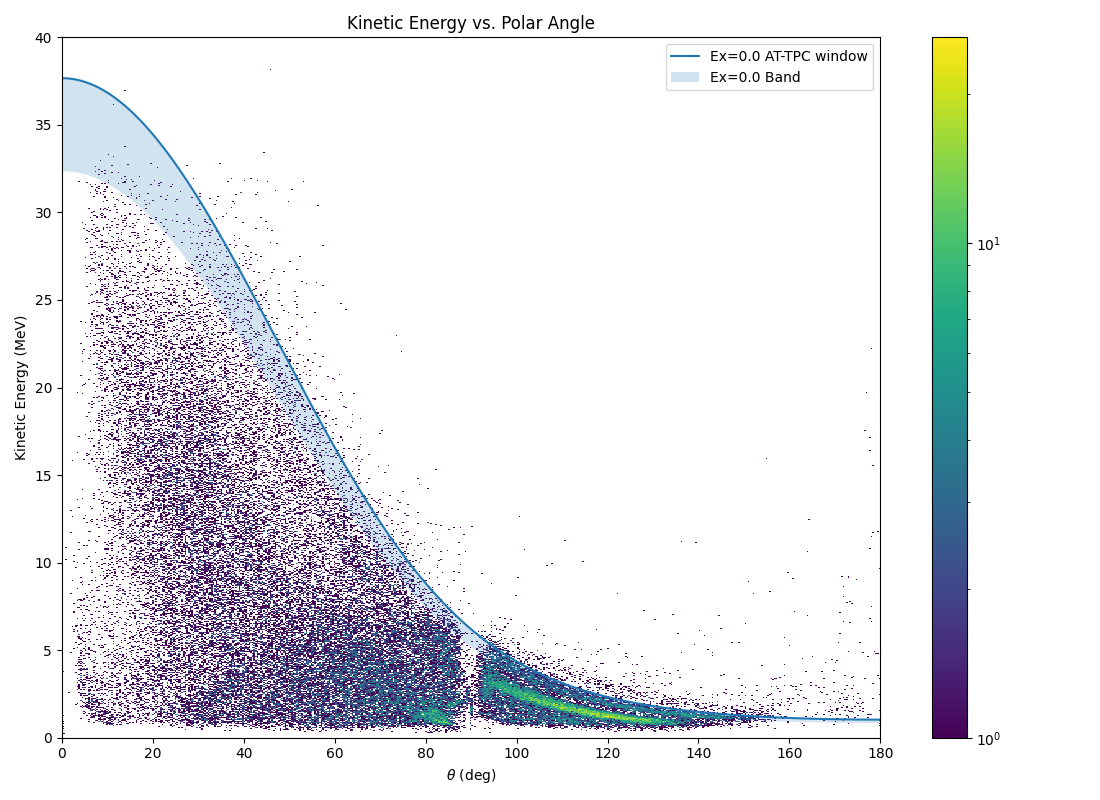

In [13]:
# Plot kinematics from data and compare with theoretical kinematics
grammer.add_hist2d('ke_theta', (500, 800), ((0.0, 180.0), (0.0, 40.0)))
grammer.fill_hist2d('ke_theta', np.rad2deg(results["polar"]), results["kinetic_energy"])
ke_theta = grammer.get_hist2d("ke_theta")

fig, ax = plt.subplots(1,1)
mesh = ax.pcolormesh(ke_theta.x_bins, ke_theta.y_bins, ke_theta.counts, norm="log")
ax.set_title("Kinetic Energy vs. Polar Angle")
ax.set_xlabel(r"$\theta$ (deg)")
ax.set_ylabel("Kinetic Energy (MeV)")
fig.colorbar(mesh, ax=ax)
for idx, ex in enumerate(residual_excitations):
    ax.plot(np.rad2deg(eject_kinematics[idx, :len(cm_angle_range), 0]), eject_kinematics[idx, :len(cm_angle_range), 1], label=f"Ex={ex:02} AT-TPC window")
    # Fill idea thanks to D. Ramirez
    ax.fill(np.rad2deg(eject_kinematics[idx, :, 0]), eject_kinematics[idx, :, 1], label=f"Ex={ex:02} Band", alpha=0.2)
fig.set_figheight(8.0)
fig.set_figwidth(11.0)
ax.legend()
fig.tight_layout()

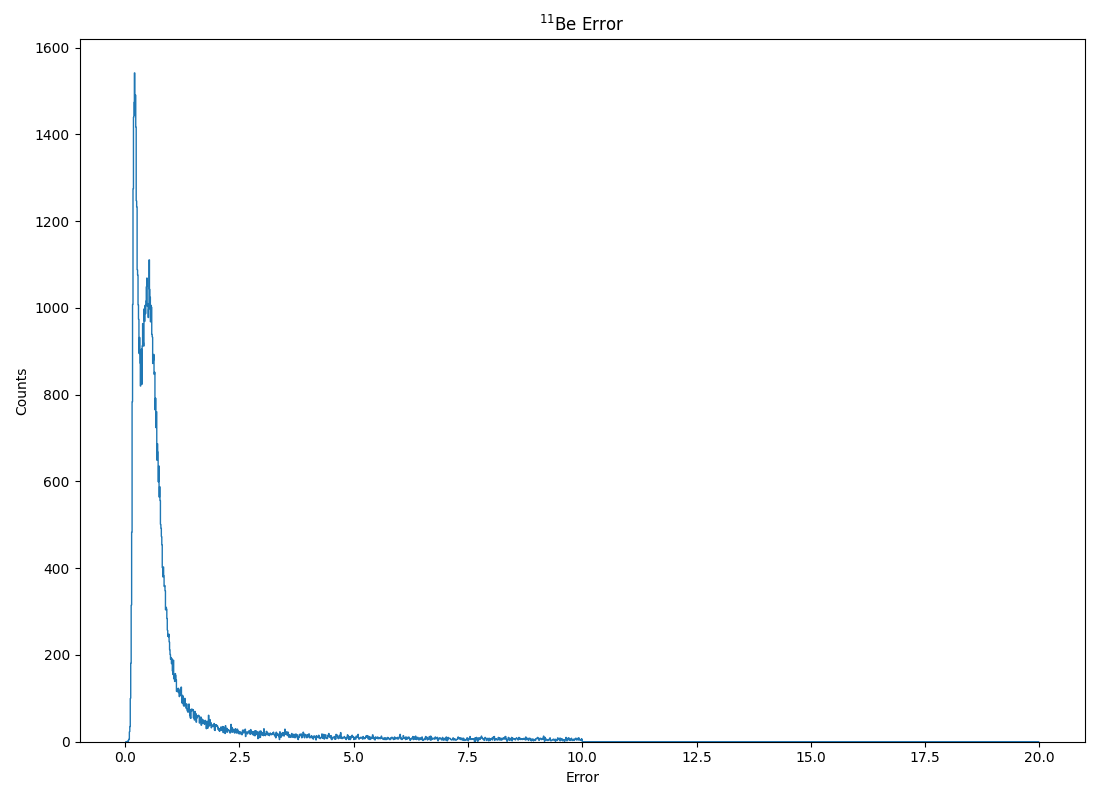

In [14]:
# Plot reduced chi-squared of fits to data

grammer.add_hist1d('chisq', 2000, (0.0, 20))
grammer.fill_hist1d("chisq", results["chisq"])
hist = grammer.get_hist1d("chisq")

fig, ax = plt.subplots(1,1)
ax.stairs(hist.counts, edges=hist.bins)
ax.set_title(f"{residual.get_latex_rep()} Error")
ax.set_xlabel("Error")
ax.set_ylabel("Counts")
fig.set_figheight(8.0)
fig.set_figwidth(11.0)
fig.tight_layout()

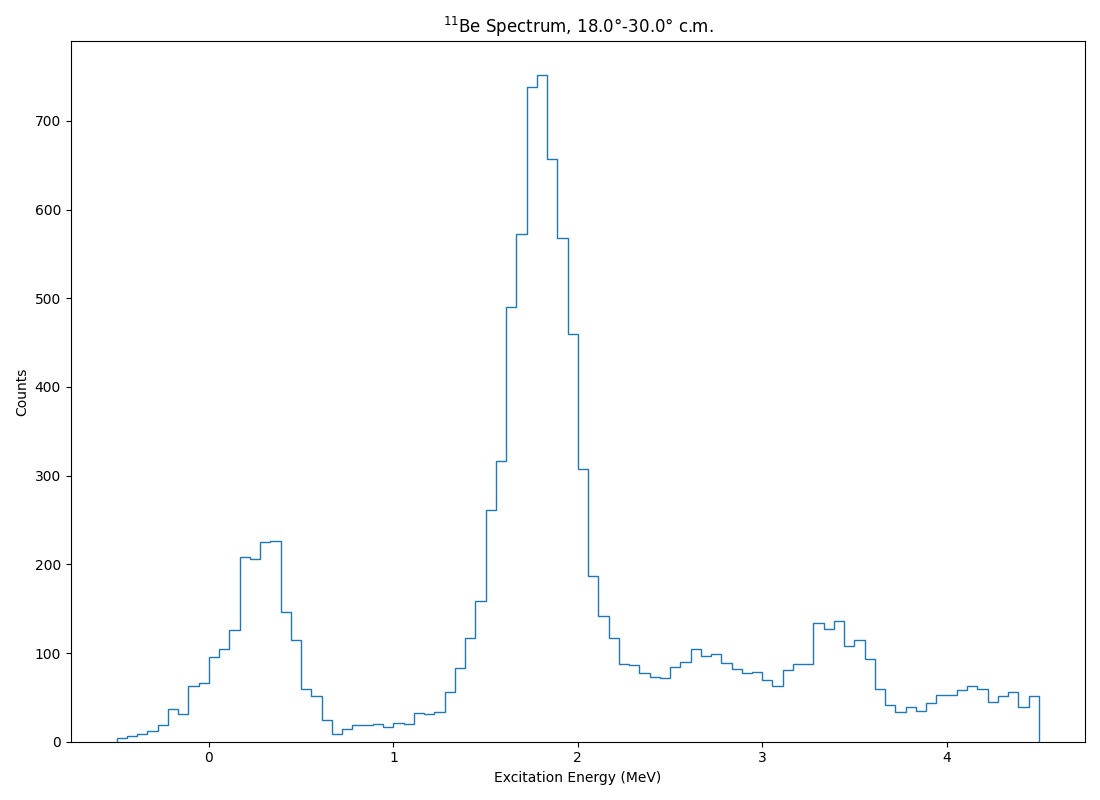

In [15]:
# Plot excitation energy spectrum

# Gate excitation spectrum on CM angle
mask_cm = (np.deg2rad(min_cm) <= results["cm_polar"]) & (results["cm_polar"] <= np.deg2rad(max_cm))    # Make note of inequalites for binning!
ex_energy_gated = results["ex_energy"][mask_cm]

grammer.add_hist1d("ex_energy",ex_energy_bins, (ex_energy_min, ex_energy_max))
grammer.fill_hist1d("ex_energy", ex_energy_gated)

ex_hist = grammer.get_hist1d("ex_energy")
fig, ax = plt.subplots(1,1)
ax.stairs(ex_hist.counts, edges=ex_hist.bins)
ax.set_title(f"{residual.get_latex_rep()} Spectrum, {min_cm}\N{DEGREE SIGN}-{max_cm}\N{DEGREE SIGN} c.m.")
ax.set_xlabel("Excitation Energy (MeV)")
ax.set_ylabel("Counts")
fig.set_figheight(8.0)
fig.set_figwidth(11.0)
fig.tight_layout()

In [16]:
# Make CM scattering angle histogram for input state

# Gate excitation spectrum on CM angle
mask_ex = (ex_en_min <= results["ex_energy"]) & (results["ex_energy"] <= ex_en_max)    # Make note of inequalites for binning!
cm_polar_gated = results["cm_polar"][mask_ex]

grammer.add_hist1d("cm_polar", ang_dist_bins, (min_cm, max_cm))
grammer.fill_hist1d("cm_polar", np.rad2deg(cm_polar_gated))

True

In [17]:
# Load background simulation config

run_min_sim = 1
run_max_sim = 9

bkgnd_sim_path = Path("E:\\engine_v0.3.0\\deuteron_bu_0-60cm\\workspace\\InterpLeastSqSolver")        # Folder of simulated runs

In [18]:
# Get shape of deuteron break up from simulations

results_bkgnd = {}

# Add keys for result parameters
results_bkgnd["polar"] = np.empty(0, float)
results_bkgnd["ex_energy"] = np.empty(0, float)
results_bkgnd["cm_polar"] = np.empty(0, float)

# Analyze simulation runs

for run in range(run_min_sim, run_max_sim+1):
    df = None

    try:
        path = bkgnd_sim_path / f"run_{run:04d}_{ejectile.isotopic_symbol}.parquet"
        df = pl.read_parquet(path)
    except Exception:
        continue

    #Apply gates to data
    df = (df.filter((pl.col("vertex_z") >= min_z) 
                   & (pl.col("vertex_z") <= max_z)
                   )
    )

    # Construct the projectile vectors (beam)
    vertices = df.select(['vertex_x', 'vertex_y', 'vertex_z']).to_numpy()
    distances = np.linalg.norm(vertices, axis=1)
    projectile_ke = proj_energy_start - target_material.get_energy_loss(projectile, proj_energy_start, distances)
    projectile_vector = vector.array({
        "px": np.zeros(len(projectile_ke)),
        "py": np.zeros(len(projectile_ke)),
        "pz": np.sqrt(projectile_ke * (projectile_ke + 2.0 * projectile.mass)),
        "E": projectile_ke + projectile.mass
    })

    # Construct the ejectile vectors (detected)
    brho = df.select('brho').to_numpy().flatten()
    momentum = df.select('brho').to_numpy().flatten() * float(ejectile.Z) * QBRHO_2_P
    kinetic_energy = np.sqrt(momentum**2.0 + ejectile.mass**2.0) - ejectile.mass
    polar = df.select('polar').to_numpy().flatten()
    az = df.select('azimuthal').to_numpy().flatten()
    ejectile_vector = vector.array({
        "px": momentum * np.sin(polar) * np.cos(az),
        "py": momentum * np.sin(polar) * np.sin(az),
        "pz": momentum * np.cos(polar),
        "E": np.sqrt(momentum**2.0 + ejectile.mass**2.0)
    })

    # Do the kinematics
    residual_vector = target_vector + projectile_vector - ejectile_vector # type: ignore
    ex_energy = residual_vector.mass - residual.mass # Excitation energy is "extra" mass

    # Calculate CM scattering angle 
    cm_vec = ejectile_vector.boostCM_of(projectile_vector + target_vector)
    cm_polar = np.pi - cm_vec.theta

    # Fill histograms and arrays
    results_bkgnd["polar"] = np.append(results_bkgnd["polar"], polar)
    results_bkgnd["ex_energy"] = np.append(results_bkgnd["ex_energy"], ex_energy)
    results_bkgnd["cm_polar"] = np.append(results_bkgnd["cm_polar"], cm_polar)

Overwriting histogram named ex_energy_sim in Histogrammer.add_histogram!


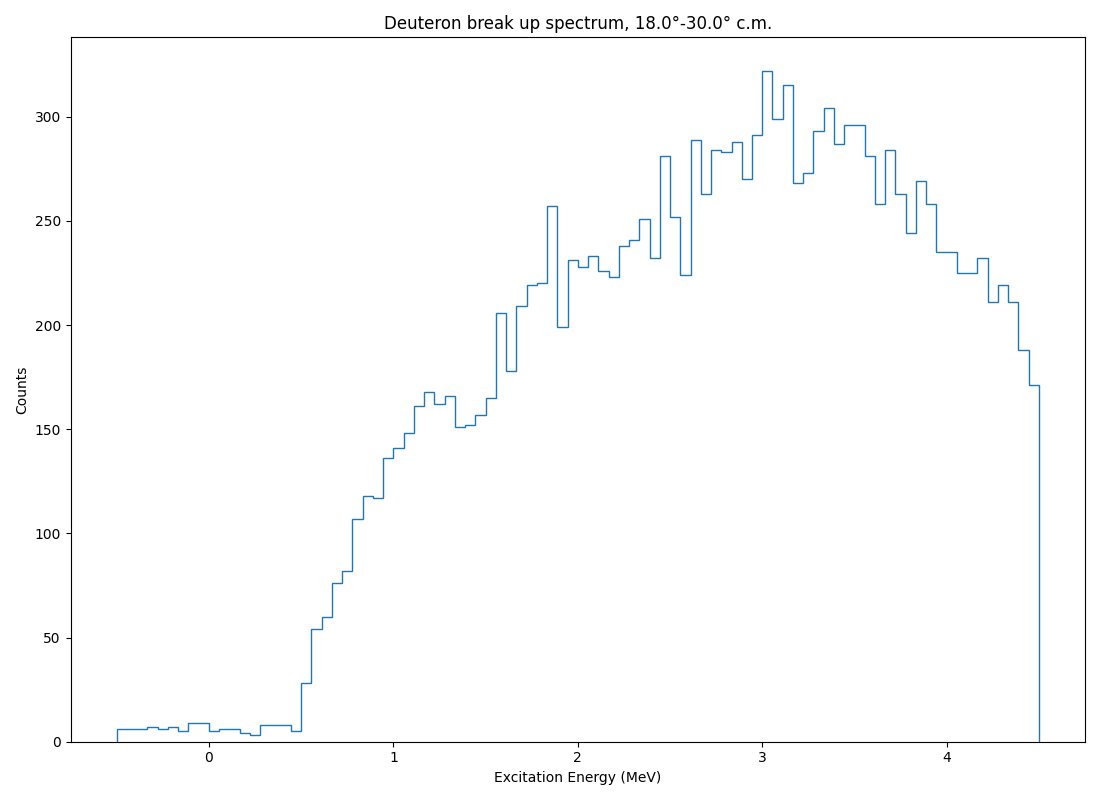

In [39]:
# Plot simulation excitation energy spectrum

# Gate excitation spectrum on CM angle
mask = (np.deg2rad(min_cm) <= results_bkgnd["cm_polar"]) & (results_bkgnd["cm_polar"] <= np.deg2rad(max_cm))    # Make note of inequalites for binning!
ex_energy_gated = results_bkgnd["ex_energy"][mask]

grammer.add_hist1d("ex_energy_sim",ex_energy_bins, (ex_energy_min, ex_energy_max))
grammer.fill_hist1d("ex_energy_sim", ex_energy_gated)

ex_hist_sim = grammer.get_hist1d("ex_energy_sim")
fig, ax = plt.subplots(1,1)
ax.stairs(ex_hist_sim.counts, edges=ex_hist_sim.bins)
ax.set_title(f"Deuteron break up spectrum, {min_cm}\N{DEGREE SIGN}-{max_cm}\N{DEGREE SIGN} c.m.")
ax.set_xlabel("Excitation Energy (MeV)")
ax.set_ylabel("Counts")
fig.set_figheight(8.0)
fig.set_figwidth(11.0)
fig.tight_layout()

In [20]:
# Characterize background in excitation spectrum

# Create dictionary to store results of excitation background removal
sub_fits = {}

# Create background shape function using simulation
bkgnd_hist = grammer.get_hist1d("ex_energy_sim")
bkgnd_bins = bkgnd_hist.bins[:-1] + bkgnd_hist.bin_width/2
bkgnd_counts = bkgnd_hist.counts

bkgnd_shape = lambda x, A: A * bkgnd_counts

# Make array of edges of angular cuts
grammer.add_hist1d("ang_dist", ang_dist_bins, (min_cm, max_cm))
ang_bins = grammer.get_hist1d("ang_dist").bins

# Make array of excitation spectrum bins
total_bins = ex_hist.bins[:-1] + ex_hist.bin_width/2

for idx in range(len(ang_bins) - 1):
    low_edge = ang_bins[idx]
    high_edge = ang_bins[idx+1]

    # Gate excitation spectrum on CM angle
    if idx != (len(ang_bins) - 1):
        mask = (np.deg2rad(low_edge) <= results["cm_polar"]) & (results["cm_polar"] < np.deg2rad(high_edge))    # Make note of inequalites for binning!
    else:
        mask = (np.deg2rad(low_edge) <= results["cm_polar"]) & (results["cm_polar"] <= np.deg2rad(high_edge))    # Make note of inequalites for binning!

    ex_energy_gated = results["ex_energy"][mask]

    # Make and fill histogram
    title = f"ex_energy_{low_edge}-{high_edge}"
    grammer.add_hist1d(title, ex_energy_bins, (ex_energy_min, ex_energy_max))
    grammer.fill_hist1d(title, ex_energy_gated)
    sub_ex_hist = grammer.get_hist1d(title)

    # Fit histogram
    peak1 = lmfit.models.VoigtModel(prefix="peak1_")
    peak1_bins, peak1_counts = sub_ex_hist.get_subrange((-0.3, 0.1))
    peak1_bins += 0.5 * sub_ex_hist.bin_width
    peak1_counts[peak1_counts == 0.0] = 1.0
    peak1_weights = np.sqrt(peak1_counts)
    peak1_weights = np.divide(1, peak1_weights, out=np.zeros_like(peak1_weights), where=peak1_weights != 0.0)
    pars = peak1.guess(x=peak1_bins, data=peak1_counts, weights=peak1_weights)
    pars["peak1_amplitude"].min = 0.0
    pars["peak1_center"].min = -0.3
    pars["peak1_center"].max = 0.1

    peak2 = lmfit.models.VoigtModel(prefix="peak2_")
    peak2_bins, peak2_counts = sub_ex_hist.get_subrange((0.1, 0.7))
    peak2_bins += 0.5 * sub_ex_hist.bin_width
    peak2_weights = np.sqrt(peak2_counts)
    peak2_weights = np.divide(1, peak2_weights, out=np.zeros_like(peak2_weights), where=peak2_weights != 0.0)
    pars.update(peak2.guess(x=peak2_bins, data=peak2_counts, weights=peak2_weights))
    pars["peak2_amplitude"].min = 0.0
    pars["peak2_center"].min = 0.1
    pars["peak2_center"].max = 0.7

    peak3 = lmfit.models.VoigtModel(prefix="peak3_")
    peak3_bins, peak3_counts = sub_ex_hist.get_subrange((1.2, 2.2))
    peak3_bins += 0.5 * sub_ex_hist.bin_width
    peak3_weights = np.sqrt(peak3_counts)
    peak3_weights = np.divide(1, peak3_weights, out=np.zeros_like(peak3_weights), where=peak3_weights != 0.0)
    pars.update(peak3.guess(x=peak3_bins, data=peak3_counts, weights=peak3_weights))
    pars["peak3_amplitude"].min = 0.0
    pars["peak3_center"].min = 1.2
    pars["peak3_center"].max = 2.2

    peak4 = lmfit.models.VoigtModel(prefix="peak4_")
    peak4_bins, peak4_counts = sub_ex_hist.get_subrange((2.4, 2.9))
    peak4_bins += 0.5 * sub_ex_hist.bin_width
    peak4_weights = np.sqrt(peak4_counts)
    peak4_weights = np.divide(1, peak4_weights, out=np.zeros_like(peak4_weights), where=peak4_weights != 0.0)
    pars.update(peak4.guess(x=peak4_bins, data=peak4_counts, weights=peak4_weights))
    pars["peak4_amplitude"].min = 0.0
    pars["peak4_center"].min = 2.4
    pars["peak4_center"].max = 2.9
    pars["peak4_fwhm"].max = 0.4

    peak5 = lmfit.models.VoigtModel(prefix="peak5_")
    peak5_bins, peak5_counts = sub_ex_hist.get_subrange((3.2, 3.7))
    peak5_bins += 0.5 * sub_ex_hist.bin_width
    peak5_weights = np.sqrt(peak5_counts)
    peak5_weights = np.divide(1, peak5_weights, out=np.zeros_like(peak5_weights), where=peak5_weights != 0.0)
    pars.update(peak5.guess(x=peak5_bins, data=peak5_counts, weights=peak5_weights))
    pars["peak5_amplitude"].min = 0.0
    pars["peak5_center"].min = 3.2
    pars["peak5_center"].max = 3.7
    pars["peak5_fwhm"].max = 0.4

    bkgnd = lmfit.Model(bkgnd_shape, prefix="bkgnd_")
    pars.update(bkgnd.make_params(A=1))
    pars["bkgnd_A"].min = 0.0

    total_fit = peak1 + peak2 + peak3 + peak4 + peak5 + bkgnd
    total_bins = sub_ex_hist.bins[:-1] + sub_ex_hist.bin_width/2
    total_counts = sub_ex_hist.counts
    total_counts[total_counts == 0.0] = 1.0
    total_weights = np.sqrt(total_counts)
    total_weights = np.divide(1, total_weights, out=np.zeros_like(total_weights), where=total_weights != 0.0)
    total_result = total_fit.fit(params=pars, x=total_bins, data=total_counts, weights=total_weights)

    # Store total fit result
    sub_fits[title] = total_result

In [21]:
idx=-1

<Parameter 'bkgnd_A', value=0.005707416782255725 +/- 0.00349, bounds=[0.0:inf]>


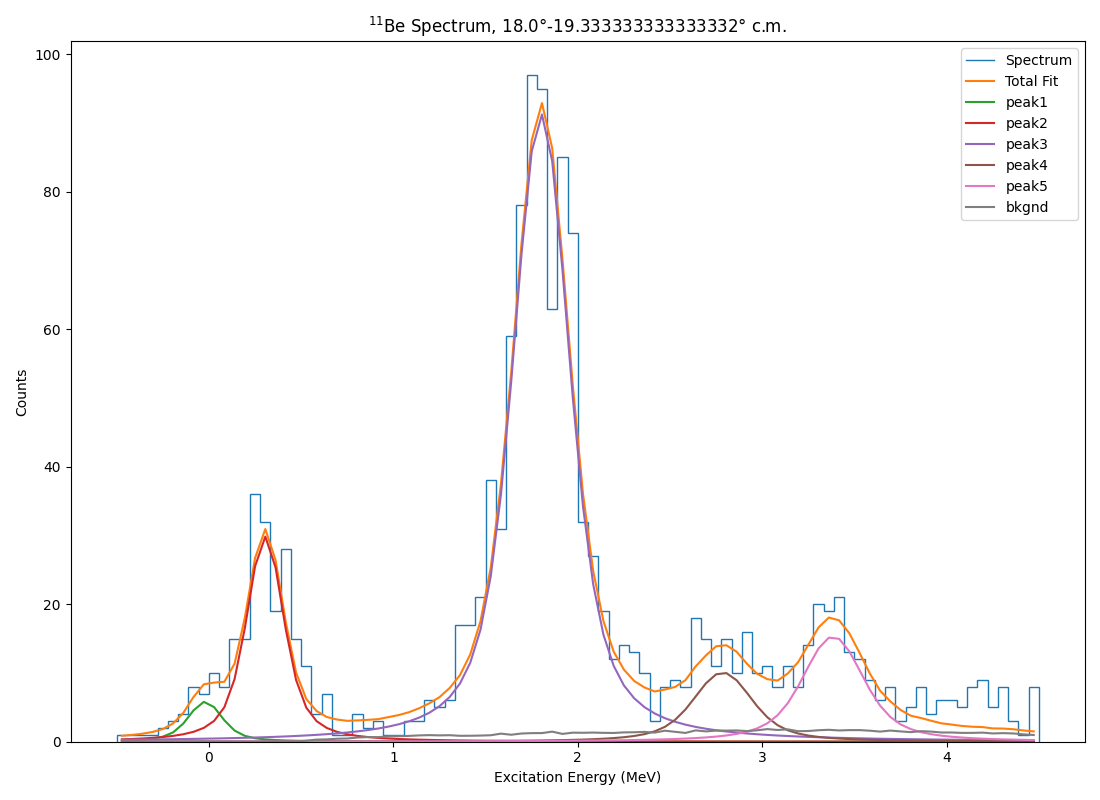

In [22]:
# Check results of the fits

idx += 1

low_edge = ang_bins[idx]
high_edge = ang_bins[idx+1]

title = f"ex_energy_{low_edge}-{high_edge}"

# Get results of fit
sub_fit_result = sub_fits[title]
comps = sub_fit_result.eval_components()
print(sub_fit_result.params['bkgnd_A'])

# Plot result
fig, ax = plt.subplots(1,1)
sub_ex_hist = grammer.get_hist1d(title)
ax.stairs(sub_ex_hist.counts, edges=sub_ex_hist.bins, label="Spectrum")
ax.plot(total_bins, sub_fit_result.best_fit, label="Total Fit")
ax.plot(total_bins, comps["peak1_"], label="peak1")
ax.plot(total_bins, comps["peak2_"], label="peak2")
ax.plot(total_bins, comps["peak3_"], label="peak3")
ax.plot(total_bins, comps["peak4_"], label="peak4")
ax.plot(total_bins, comps["peak5_"], label="peak5")
ax.plot(total_bins, comps["bkgnd_"], label="bkgnd")
ax.set_title(f"{residual.get_latex_rep()} Spectrum, {low_edge}\N{DEGREE SIGN}-{high_edge}\N{DEGREE SIGN} c.m.")
ax.set_xlabel("Excitation Energy (MeV)")
ax.set_ylabel("Counts")
fig.set_figheight(8.0)
fig.set_figwidth(11.0)
ax.legend()
fig.tight_layout()

In [23]:
# Subtract background from excitation spectrum

grammer.add_hist1d("ex_energy_bkgnd_rm", ex_energy_bins, (ex_energy_min, ex_energy_max))
ex_hist_bkgnd_rm = grammer.get_hist1d("ex_energy_bkgnd_rm")
ex_counts = ex_hist_bkgnd_rm.counts.copy()

for title, fit in sub_fits.items():
    sub_ex_hist = grammer.get_hist1d(title)
    strength = fit.params["bkgnd_A"].value
    sub_ex_hist_counts = sub_ex_hist.counts - bkgnd_shape(_, strength)

    # MAY BE BAD, NOT ALLOWING NEGATIVE COUNTS
    neg_mask = sub_ex_hist_counts < 0
    sub_ex_hist_counts[neg_mask] = 0

    ex_counts = ex_counts + sub_ex_hist_counts

ex_hist_bkgnd_rm.counts = ex_counts

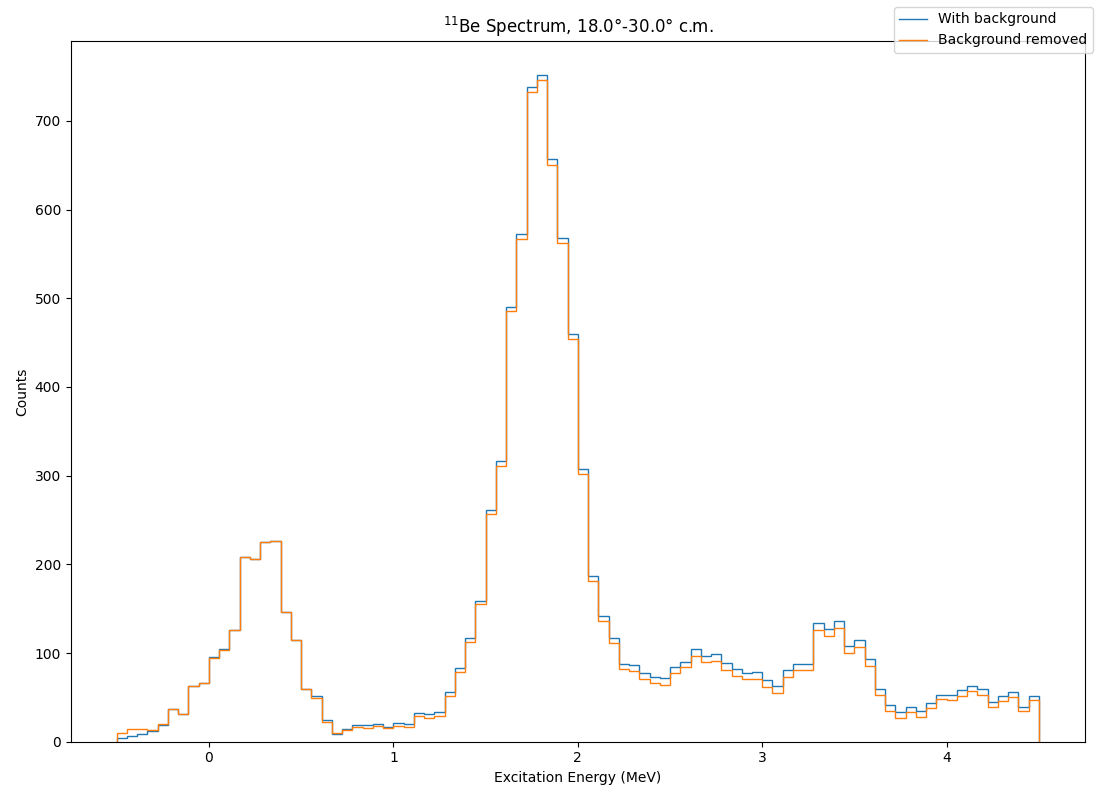

In [24]:
# Plot residual excitation energy spectrum with background removed

fig, ax = plt.subplots(1,1)
ax.stairs(ex_hist.counts, edges=ex_hist.bins, label="With background")
ax.stairs(ex_hist_bkgnd_rm.counts, edges=ex_hist_bkgnd_rm.bins, label="Background removed")
ax.set_title(f"{residual.get_latex_rep()} Spectrum, {min_cm}\N{DEGREE SIGN}-{max_cm}\N{DEGREE SIGN} c.m.")
ax.set_xlabel("Excitation Energy (MeV)")
ax.set_ylabel("Counts")
fig.set_figheight(8.0)
fig.set_figwidth(11.0)
fig.legend()
fig.tight_layout()

In [25]:
# Find analysis efficiency correction

# Parameters
eff_sim_events_path = Path("E:\\engine_v0.3.0\\dp_3.4mev_0-60cm\\new\\InterpLeastSqSolver")
eff_sim_cm_path = Path("E:\\engine_v0.3.0\\dp_3.4mev_0-60cm\\cm_ang.npy")
run_min_eff = 1
run_max_eff = 12

# Store results
results_eff = {}
results_eff["cm_polar"] = np.empty(0, float)
results_eff["ex_energy"] = np.empty(0, float)
results_eff["chisq"] = np.empty(0, float)

for run in range(run_min_eff, run_max_eff+1):
    df = None
    path = eff_sim_events_path / f"run_{run:04d}_{ejectile.isotopic_symbol}.parquet"
    if not path.exists():
        print(f"{run} does have a solver file!")
        continue
    df = pl.scan_parquet(path)

    #Apply gates to data
    df = (df.filter((pl.col("vertex_z") >= min_z) 
                   & (pl.col("vertex_z") <= max_z)
                   )
            .collect()
    )

    # Construct the projectile vectors (beam)
    vertices = df.select(['vertex_x', 'vertex_y', 'vertex_z']).to_numpy()
    distances = np.linalg.norm(vertices, axis=1)
    projectile_ke = proj_energy_start - target_material.get_energy_loss(projectile, proj_energy_start, distances)
    projectile_vector = vector.array({
        "px": np.zeros(len(projectile_ke)),
        "py": np.zeros(len(projectile_ke)),
        "pz": np.sqrt(projectile_ke * (projectile_ke + 2.0 * projectile.mass)),
        "E": projectile_ke + projectile.mass
    })

    # Construct the ejectile vectors (detected)
    brho = df.select('brho').to_numpy().flatten()
    momentum = df.select('brho').to_numpy().flatten() * float(ejectile.Z) * QBRHO_2_P
    kinetic_energy = np.sqrt(momentum**2.0 + ejectile.mass**2.0) - ejectile.mass
    polar = df.select('polar').to_numpy().flatten()
    az = df.select('azimuthal').to_numpy().flatten()
    ejectile_vector = vector.array({
        "px": momentum * np.sin(polar) * np.cos(az),
        "py": momentum * np.sin(polar) * np.sin(az),
        "pz": momentum * np.cos(polar),
        "E": np.sqrt(momentum**2.0 + ejectile.mass**2.0)
    })

    # Calculate CM scattering angle 
    cm_vec = ejectile_vector.boostCM_of(projectile_vector + target_vector)
    cm_polar = np.pi - cm_vec.theta

    # Do the kinematics
    residual_vector = target_vector + projectile_vector - ejectile_vector # type: ignore
    ex_energy = residual_vector.mass - residual.mass # Excitation energy is "extra" mass

    # Get reduced chi-squared information
    cs = df.select('redchisq').to_numpy().flatten()

    # Fill array
    results_eff["cm_polar"] = np.append(results_eff["cm_polar"], cm_polar)
    results_eff["ex_energy"] = np.append(results_eff["ex_energy"], ex_energy)
    results_eff["chisq"] = np.append(results_eff["chisq"], cs)

# Histogram of simulated CM angles that made it through analysis
mask_ex = (ex_en_min <= results_eff["ex_energy"]) & (results_eff["ex_energy"] <= ex_en_max)    # Make note of inequalites for binning!

grammer.add_hist1d("cm_polar_sim_observed", ang_dist_bins, (min_cm, max_cm))
grammer.fill_hist1d("cm_polar_sim_observed", np.rad2deg(results_eff["cm_polar"][mask_ex]))
hist_obs = grammer.get_hist1d("cm_polar_sim_observed")

# Histogram of all simulated CM angles that made it through detector effects
eff_all_cm_ang = np.load(eff_sim_cm_path)
grammer.add_hist1d("cm_polar_sim_all", ang_dist_bins, (min_cm, max_cm))
grammer.fill_hist1d("cm_polar_sim_all", np.rad2deg(eff_all_cm_ang))
hist_all = grammer.get_hist1d("cm_polar_sim_all")

# Efficiency factors and error
eff_factors = hist_all.counts/hist_obs.counts
eff_factors_err = eff_factors * np.sqrt(1 / hist_all.counts + 1 / hist_obs.counts)

In [36]:
# Subtract background from CM scattering angle histogram and apply efficency factors

grammer.add_hist1d("cm_polar_corr", ang_dist_bins, (min_cm, max_cm))
cm_hist = grammer.get_hist1d("cm_polar")
cm_counts = cm_hist.counts.copy()

ex_hist_sim = grammer.get_hist1d("ex_energy_sim")
cm_hist_sim_counts, _, _ = ex_hist_sim.stats_for_range((ex_en_min, ex_en_max))

# Make CM scattering angle histogram for input state

# # Gate excitation spectrum on CM angle
# mask_ex_sim = (ex_en_min <= results_bkgnd["ex_energy"]) & (results_bkgnd["ex_energy"] <= ex_en_max)    # Make note of inequalites for binning!
# cm_polar_sim_gated = results_bkgnd["cm_polar"][mask_ex_sim]
# grammer.add_hist1d("cm_polar_sim", ang_dist_bins, (min_cm, max_cm))
# grammer.fill_hist1d("cm_polar_sim", np.rad2deg(cm_polar_sim_gated))
# cm_polar_sim_hist = grammer.get_hist1d("cm_polar_sim")

for idx, fit in enumerate(sub_fits.items()):
    # THIS AUTOMATICALLY CONVERTS TO INTS, BE CAREFUL
    strength = fit[1].params["bkgnd_A"].value
    # cm_counts[idx] *= (1 - strength)
    cm_counts[idx] -= strength * cm_hist_sim_counts
    # cm_counts[idx] -= strength * cm_polar_sim_hist.counts[idx]

print(cm_polar_sim_hist.counts)
cm_hist_corr = grammer.get_hist1d("cm_polar_corr")
cm_hist_corr.counts = cm_counts * eff_factors


Overwriting histogram named cm_polar_corr in Histogrammer.add_histogram!
Overwriting histogram named cm_polar_sim in Histogrammer.add_histogram!
[139 168 124 120  98 102 100 109  99]
[138 167 122 119  97  99  97 107  97]
[174 254 322 358 374 383 397 426 407]


In [27]:
# Calculate cross section

beam_counts *= downscale_factor     # Units of counts

length = max_z - min_z    # Units of meters
nuclei_areal_density = pressure * torr_2_pascal * length / boltzmann / temperature * stoich * 1.0e-31 # Units of target nuclei / millibarns

cm_hist_corr = grammer.get_hist1d("cm_polar_corr")
bins = cm_hist_corr.bins
bin_width = cm_hist_corr.bin_width

xs = cm_hist_corr.counts  / np.diff(np.cos(np.deg2rad(bins))) / (-2 * np.pi * beam_counts * nuclei_areal_density)   # Units of millibarns / steradians
# err = np.sqrt(cm_hist_corr.counts) / np.diff(np.cos(np.deg2rad(bins))) / (-2 * np.pi * beam_counts * nuclei_areal_density)
err = np.sqrt((eff_factors * np.sqrt(cm_hist.counts))**2 + (cm_hist.counts * eff_factors_err)**2) / np.diff(np.cos(np.deg2rad(bins))) / (-2 * np.pi * beam_counts * nuclei_areal_density)

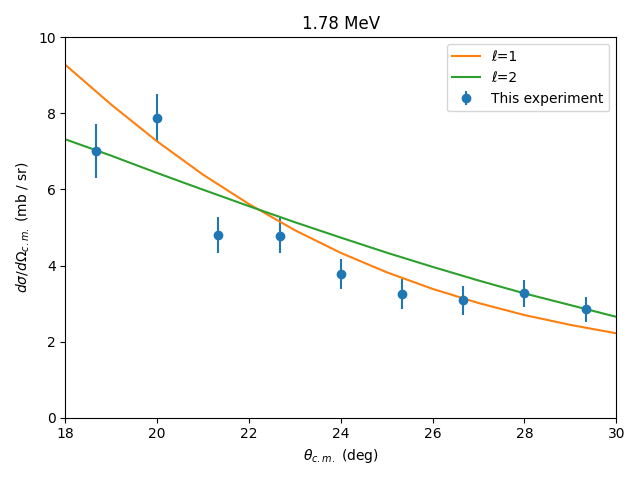

In [28]:
# Plot angular distribution

# Ptolemy DWBA calculations
es3_l1 = pl.read_csv("D:\\ptolemy\\11Be\\3.4_mev\\l1\\beam_93mev.csv")
es3_l1_93 = es3_l1.to_dict(as_series=True)
es3_l2 = pl.read_csv("D:\\ptolemy\\11Be\\3.4_mev\\l2\\beam_93mev.csv")
es3_l2_93 = es3_l2.to_dict(as_series=True)
es2_l2 = pl.read_csv("D:\\ptolemy\\11Be\\1.78_mev\\l2\\beam_93mev.csv")
es2_l2_93 = es2_l2.to_dict(as_series=True)
es2_l1 = pl.read_csv("D:\\ptolemy\\11Be\\1.78_mev\\l1\\beam_93mev.csv")
es2_l1_93 = es2_l1.to_dict(as_series=True)

fig, ax = plt.subplots(1,1)
ax.errorbar(bins[:len(bins)-1]+bin_width/2, xs, yerr=err, fmt='o', label="This experiment")

ax.plot(es3_l1_93['cm_angle'],es3_l1_93['xs_mb']*0.345, label="ℓ=1")
ax.plot(es3_l2_93['cm_angle'],es3_l2_93['xs_mb']*0.155, label="ℓ=2")
# ax.plot(es2_l1_93['cm_angle'],es2_l1_93['xs_mb']*1.7, label="ℓ=1, S=1.7")
# ax.plot(es2_l2_93['cm_angle'],es2_l2_93['xs_mb']*.59, label="ℓ=2, S=0.59")

#elastic
# elastic_an_cai = pl.read_csv("C:\\Users\\zachs\\Desktop\\elastic_an_cai_93.5.csv")
# elastic_an_cai_d = elastic_an_cai.to_dict(as_series=True)
# ax.plot(elastic_an_cai_d['cm_angle'],elastic_an_cai_d['cm_xs'], label="An Cai")

# wb_data = {"x": [8.2,
#                  11.0, 
# 14.0, 19.6, 
# 22.5, 25.5, 
# 28.3, 31.1, 
# 33.9, 36.7, 
# 39.8, 45.1, 
# 50.8, 56.1, 
# 61.8],

# "y": [47.1,
# 45.0, 
# 37.9, 19.0, 
# 15.0, 9.8, 
# 7.5, 4.9, 
# 3.7, 2.7, 
# 1.9, 1.3, 
# 1.4, 1.4, 
# 1.1]}
# ax.plot(wb_data["x"],wb_data["y"], 'rv', label=r"Zwieglinksi, B. $et$ $al$.")

ax.set_title(f"{residual.get_latex_rep()} CM Scattering Angle")
ax.set_title("1.78 MeV")
ax.set_xlabel(r"$\theta_{c.m.}$ (deg)")
ax.set_ylabel(r"$d\sigma / d\Omega_{c.m.}$ (mb / sr)")
ax.legend()
plt.xlim(min_cm, max_cm)
# plt.semilogy()
plt.ylim(0,10)
# fig.set_figwidth(8.0)
# fig.set_figwidth(11.0)
fig.tight_layout()

In [29]:
# np.savetxt("C:\\Users\\zachs\\Desktop\\elastic_xs.csv", np.array([bins[:len(bins)-1]+bin_width/2, xs, err]).T, newline="\n", fmt="%.4f", delimiter=",")

In [30]:
l1 = lambda x, A: A * np.interp(x, es3_l1_93["cm_angle"], es3_l1_93["xs_mb"])

l2 = lambda x, A: A * np.interp(x, es3_l2_93["cm_angle"], es3_l2_93["xs_mb"])

params = lmfit.Parameters()

l1_fit = lmfit.Model(l1, prefix="l1_")
params.add("l1_A", value=1, min=0)

fit_weights = np.sqrt(xs)
fit_weights = np.divide(1, fit_weights, out=np.zeros_like(fit_weights), where=fit_weights != 0.0)
total_result = l1_fit.fit(params=params, x=bins[:len(bins)-1]+bin_width/2, data=xs, weights=fit_weights)

total_result